In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
autoBase = automap_base()
# reflect the tables
autoBase.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
autoBase.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
stations = autoBase.classes.station
measurements = autoBase.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(measurements.date).order_by(measurements.date.desc()).first()

('2017-08-23',)

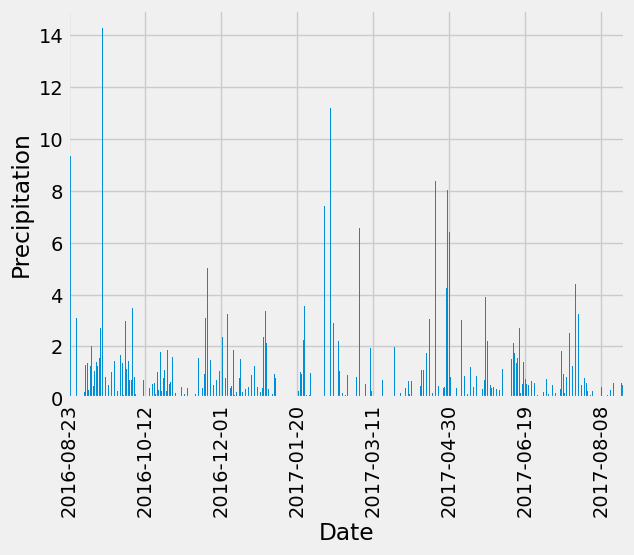

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastDate = session.query(measurements.date).order_by(measurements.date.desc()).first()
# Calculate the date one year from the last date in data set.
lastDate = dt.datetime.strptime(lastDate[0], '%Y-%m-%d').date()
yearBack = lastDate - dt.timedelta(days=365)
yearBack = dt.date.strftime(yearBack, '%Y-%m-%d')
# Perform a query to retrieve the date and precipitation scores
precipQuery = session.query(measurements.date, measurements.prcp).filter(measurements.date >= yearBack).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipData = pd.DataFrame(precipQuery)
precipData = precipData.rename(columns={'date': 'Date', 'prcp': 'Precipitation'})
# Sort the dataframe by date
precipData = precipData.sort_values(by="Date", ascending=True).reset_index(drop=True)
precipData = precipData.groupby(["Date"])["Precipitation"].sum()

# Use Pandas Plotting with Matplotlib to plot the data
precipData.plot(kind="bar", x="Date", y="Precipitation", ylabel="Precipitation")
plt.xticks(np.arange(0, 400, 50))
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipData.describe()

count    366.000000
mean       0.978907
std        1.776349
min        0.000000
25%        0.052500
50%        0.405000
75%        1.087500
max       14.280000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(stations).distinct().count()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(stations.station, func.count(measurements.id)).\
    filter(stations.station == measurements.station).group_by(stations.station).\
    order_by(func.count(measurements.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(stations.station == measurements.station).\
    filter(stations.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature (F)')

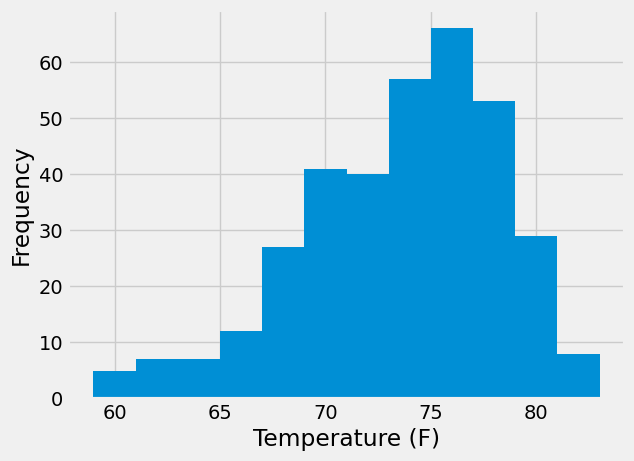

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearTemp = session.query(measurements.tobs).\
    filter(stations.station == measurements.station).\
    filter(stations.station == 'USC00519281').\
    filter(measurements.date >= yearBack).all()
tempData = pd.DataFrame(yearTemp)
plt.hist(tempData, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")

# Close Session

In [17]:
# Close Session
session.close()